In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis

from mri_data import file_manager as fm
import helpers

In [141]:
reload_recursive(helpers)

## Setup

In [162]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False

In [17]:
# from mri_data.file_manager import scan_3Tpioneer_bids
# from mri_data import file_manager as fm
# from mri_data import utils
# from monai_training.preprocess import DataSetProcesser
# from loguru import logger

# logger.remove()

# df = pd.read_csv(data_dir / "t1_data_full.csv")
# mod = "t1"

# config = {
#     "t1": "t1_choroid_pineal_pituitary_T1-1_pred",
#     "flair": "flair_choroid_pineal_pituitary_FLAIR-1_pred",
# }


# inference_root = drive_root / "srs-9" / "3Tpioneer_bids_predictions"
# dataroot = drive_root / "3Tpioneer_bids"
# clinical_data_root = drive_root / "Secure_Data" / "Large"
# data_file_folder = Path("/home/srs-9/Projects/ms_mri/analysis/paper1/data0")
# inf_label = config[mod]

# def subject_to_subid(subject):
#     if not isinstance(subject, str):
#         return None
#     re_match = re.match(r"ms(\d{4})", subject)
#     if re_match:
#         return_val = int(re_match[1])
#         return return_val
#     else:
#         return None

# new_columns = {
#     "ID": "subject",
#     "age_at_obs_start": "age",
# }
# df.rename(columns=new_columns, inplace=True)
# df["subid"] = df["subject"].apply(subject_to_subid)
# df.drop(df[df["subid"].isna()].index, inplace=True)
# df["subid"] = df["subid"].astype(int)
# df = df.set_index("subid")

# new_columns = {}
# for col in df.columns:
#     new_columns[col] = col.replace(" ", "_")
# df.rename(columns=new_columns, inplace=True)


# dataset_proc = DataSetProcesser.new_dataset(
#     dataroot, scan_3Tpioneer_bids, filters=[fm.filter_first_ses]
# )
# full_dataset = dataset_proc.dataset
# dataset_proc.prepare_labels(
#     ["choroid_t1_flair", "pineal", "pituitary"], ["CH", "SRS", "ED", "DT"]
# )
# dataset = dataset_proc.dataset

# inference_dataset_proc = DataSetProcesser.new_dataset(
#     inference_root, scan_3Tpioneer_bids, filters=[fm.filter_first_ses]
# )
# inference_dataset_proc.prepare_labels(inf_label)
# inference_dataset = inference_dataset_proc.dataset


# segs = {}
# for scan in dataset:
#     segs[scan.subid] = scan.label_path
#     df.loc[int(scan.subid), ("sub-ses",)] = scan.relative_path
#     df.loc[int(scan.subid), ("label_folder",)] = scan.label_path.relative_to(drive_root).parent
#     df.loc[int(scan.subid), ("label",)] = scan.label

# for scan in inference_dataset:
#     segs[scan.subid] = scan.label_path
#     df.loc[int(scan.subid), ("sub-ses",)] = scan.relative_path
#     df.loc[int(scan.subid), ("label_folder",)] = scan.label_path.relative_to(drive_root).parent
#     df.loc[int(scan.subid), ("label",)] = scan.label


# df.to_csv(data_dir / "t1_data_full.csv")

In [163]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
# df.loc[df["sub-ses"].isna(), "sub-ses"]

# thoo = [132, 133, 134]
# df[(df.index.isin(thoo)) & (df["flair_contrast"] == "WITHOUT")]

In [177]:
dataroot = Path("/mnt/h/3Tpioneer_bids")

t1_gd_scans = []
for i, row in df.iterrows():
    if (dataroot / str(row['sub-ses']) / "t1_gd.nii.gz").is_file():
        t1_gd_scans.append(row['subid'])

In [176]:
(dataroot / str(df.loc[0, "sub-ses"]) / "t1_gd.nii.gz").is_file()

True

In [150]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df["Intercept"] = 1

In [151]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])

In [152]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume"
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [153]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

In [154]:
vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

df_scale = df.copy()
df_scale[vars_to_scale] = df_scale[vars_to_scale] / df_scale[vars_to_scale].mean()

In [155]:
df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

In [156]:
r_data_dir = Path("/mnt/c/Users/srs-9/Dev/ms_mri/analysis/paper1/data")
df.dropna().to_csv(r_data_dir / "proc_data.csv")
df_ms.dropna().to_csv(r_data_dir / "proc_data_ms.csv")
df_scale.dropna().to_csv(r_data_dir / "proc_data_scale.csv")
df_scale_ms.dropna().to_csv(r_data_dir / "proc_data_scale_ms.csv")

## Analysis

### Choroid Volumes

CP volume increased with age (β=0.38, p<0.001), TIV (β=0.16, p=0.001), and was smaller in females (β=-0.15, p=0.002), but was not associated with the presence of MS (β=0.18, p=0.10)

In [26]:
model_data = df_z[df_z['dz_type2'].isin(["MS", "!MS"])]
res = sm.OLS.from_formula(
    "choroid_volume ~ dz_type2 + age + tiv + Female", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.236
R2_adj: 0.230
                    coef             p
Intercept      -0.150227  1.433637e-01
dz_type2[T.MS]  0.182786  1.021872e-01
age             0.384761  1.688386e-19
tiv             0.160233  1.070275e-03
Female         -0.153129  1.849241e-03


Within the population of MS patients, those with PMS had greater CP volumes than those with RMS, after controlling for age, sex, and TIV (β=0.36, p=0.003). 

In [27]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.254
R2_adj: 0.246
                     coef             p
Intercept        0.314614  3.053937e-03
dz_type5[T.RMS] -0.358740  3.328932e-03
Female          -0.162634  2.373544e-03
age              0.320690  8.375234e-11
tiv              0.134778  1.163134e-02


In a multivariable regression controlling for age, sex, and TIV, CP volume increased with WM lesion volume (β=0.21, p<0.001) and number of PRL lesions (β=0.16, p<0.001). There was still a significant positive association with PMS (β=0.27. p=0.019)

In [28]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ lesion_vol_cubic + PRL + dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.334
R2_adj: 0.325
                      coef             p
Intercept         0.220771  3.096051e-02
dz_type5[T.RMS]  -0.274278  1.941262e-02
lesion_vol_cubic  0.212075  4.608245e-06
PRL               0.162715  7.904203e-05
Female           -0.165620  1.138366e-03
age               0.322206  1.198592e-10
tiv               0.109367  3.140712e-02


An ANCOVA was conducted to examine differences in CP volume amongst the RMS, PMS, OIND, and NIND groups, controlling for age, sex, and TIV. The analysis revealed a significant main effect for disease phenotype on CP volume (p < 0.001). Post hoc Tukey's HSD comparisons indicated that PMS had significantly larger CP than both NIND (p=0.043, d=0.51) and RMS (p=0.011, d=0.42). Additionally, sex (p<0.001), age (p<0.001), and TIV (p=0.006) were significant covariates. 

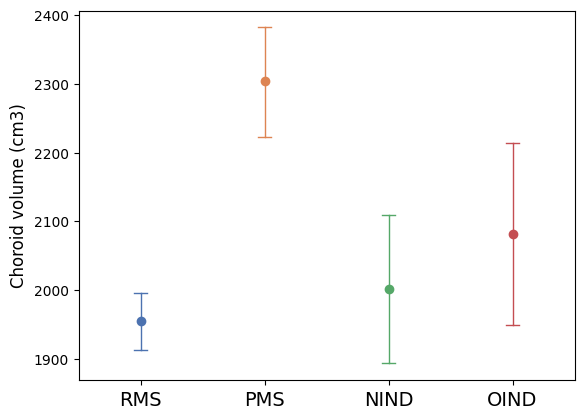

In [103]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS", "NIND", "OIND"])]
model_data = model_data[model_data['flair_contrast'] == "WITH"]

res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv + lesion_vol_cubic + DMT_hx_all", data=model_data).fit()
# Extract marginal means (using 'Group')
marginal_means = res.predict(model_data[['Female', 'age', 'tiv', 'dz_type5', 'lesion_vol_cubic', 'DMT_hx_all']].drop_duplicates())

f = plt.figure()
ax = sns.pointplot(x='dz_type5', y=marginal_means, data=model_data, 
              palette='deep', hue='dz_type5', legend=False, markers='o', linestyles='-', color='red', 
              capsize=0.1, markersize=5, markeredgewidth=2, linewidth=1)
ax.set_ylabel("Choroid volume (cm3)", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(["RMS", "PMS", "NIND", "OIND"])
ax.set_xticklabels(["RMS", "PMS", "NIND", "OIND"], fontsize=14)
f.patch.set_alpha(0)

In [91]:
model_data['dzdur']

subid
1001    14.039314
1002     1.138915
1003    14.239172
1004     3.931446
1005    19.514866
          ...    
2136     0.657066
2137     3.058096
2138          NaN
2140     1.478399
2142          NaN
Name: dzdur, Length: 485, dtype: float64

The best performing regression model for predicting CP volume in MS patients had an R² of 0.37 (adj R²=0.35).

In [30]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("choroid_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + lesion_count + PRL + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     23.84
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           5.10e-32
Time:                        13:03:23   Log-Likelihood:                -2899.9
No. Observations:                 376   AIC:                             5820.
Df Residuals:                     366   BIC:                             5859.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          682.2914    473.217  

### PRL Count

Choroid predicts PRL count after controlling for age, sex, tiv, and lesion volume. Show the analysis

In [65]:
mediator_model = sm.GLM.from_formula("PRL ~ lesion_vol_cubic + age + Female + tiv + choroid_volume", data=df_scale_ms, family=sm.families.Poisson())
res = mediator_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  410
Model:                            GLM   Df Residuals:                      404
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -712.54
Date:                Thu, 27 Feb 2025   Deviance:                       995.12
Time:                        13:18:46   Pearson chi2:                 1.27e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4470
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7724      0.714  

### Clinical Disability

In [126]:
model_data = df.copy()
# model_data = model_data[model_data['flair_contrast'] == "WITHOUT"]

model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :]
predictors = ["choroid_volume", "tiv", "age", "Female"]
outcome = ["EDSS"]
model_data[predictors] = model_data[predictors].apply(stats.zscore, nan_policy='omit')

model_data2 = data.copy()
model_data2['age'] = model_data2['choroid_volume'] - (model_data2['choroid_volume']).mean()

model = sm.OLS.from_formula("edss_sqrt ~ lesion_count + PRL + tiv + age + Female", data=model_data)
res = model.fit()
print(res.summary())
# print("p values:")
# print("Choroid volume: {:0.2}".format(res_prob.pvalues['choroid_volume']))
# print("Lesion volume:  {:0.2}".format(res_prob.pvalues['lesion_vol_cubic']))

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     23.94
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           5.26e-21
Time:                        15:51:52   Log-Likelihood:                -289.08
No. Observations:                 395   AIC:                             590.2
Df Residuals:                     389   BIC:                             614.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4728      0.035     42.107   

In [124]:
model_data = df_scale.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()

mod_prob = OrderedModel.from_formula("EDSS ~ PRL + tiv + age + Female",
                                     data=model_data, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.190125
         Iterations: 77
         Function evaluations: 79
         Gradient evaluations: 79


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -812.54
Model:                   OrderedModel   AIC:                             1667.
Method:            Maximum Likelihood   BIC:                             1749.
Date:                Fri, 28 Feb 2025                                         
Time:                        15:51:02                                         
No. Observations:                 371                                         
Df Residuals:                     350                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRL            0.1034      0.042      2.474      0.013       0.021       0.185
tiv           -1.3265      1.296     -1.024      0.306      -3.867       1.214
age            3.4101      0.397      8.590      0.000       2.632       4.188
Female        -0.2848      0.266     -1.069      0.285      -0.807       0.237
0.0/1.0       -2.4345      1.547     -1.574      0.116      -5.467       0.598
1.0/1.5        0.9753      0.151      6.446      0.000       0.679       1.272
1.5/2.0        0.3874      0.094      4.140      0.000       0.204       0.571
2.0/2.5       -0.3045      0.124     -2.454      0.014      -0.548      -0.061
2.5/3.0       -1.3054      0.218     -5.997      0.000      -1.732      -0.879
3.0/3.5       -1.1684      0.207     -5.648      0.000      -1.574      -0.763
3.5/4.0       -1.2278      0.223     -5.499      0.000      -1.665      -0.790
4.0/4.5       -1.2832      0.244     -5.261      0.000      -1.761      -0.805
4.5/5.0       -2.5982      0.497     -5.232      0.000      -3.572      -1.625
5.0/5.5       -1.9922      0.374     -5.332      0.000      -2.725      -1.260
5.5/6.0       -2.4942      0.497     -5.022      0.000      -3.468      -1.521
6.0/6.5       -0.2007      0.176     -1.138      0.255      -0.546       0.145
6.5/7.0        0.0030      0.228      0.013      0.990      -0.444       0.450
7.0/7.5       -0.9465      0.498     -1.899      0.058      -1.923       0.030
7.5/8.0       -0.8638      0.577     -1.497      0.135      -1.995       0.267
8.0/8.5       -0.3410      0.584     -0.584      0.560      -1.487       0.804
8.5/9.0        0.1048      0.740      0.142      0.887      -1.345       1.554
==============================================================================
"""

#### MSSS

In [20]:
model = sm.OLS.from_formula("msss_sqrt ~ tiv + Female + lesion_vol_cubic + choroid_volume", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              msss_sqrt   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.268
Date:                Sat, 22 Feb 2025   Prob (F-statistic):             0.0613
Time:                        16:36:36   Log-Likelihood:                -417.23
No. Observations:                 403   AIC:                             844.5
Df Residuals:                     398   BIC:                             864.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5095      0.522  

#### ARMSS

In [21]:
model = sm.OLS.from_formula("armss_sqrt ~ choroid_volume + tiv + Female + age", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.939
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           3.49e-06
Time:                        16:36:50   Log-Likelihood:                -412.59
No. Observations:                 440   AIC:                             835.2
Df Residuals:                     435   BIC:                             855.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0896      0.480      6.

### Mediation

In [20]:
p2 = Process(data=data_ms_z, model=3, x="choroid_volume", y="edss_sqrt", w="dzdur",
            m=["lesion_vol_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 3

Variables:
    Cons = Cons
    x = choroid_volume
    y = edss_sqrt
    w = dzdur
    m = lesion_vol_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
412

***************************** OUTCOME MODELS ****************************

Outcome = edss_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2929   0.2727 0.7273 15.9886   10  386   0.0000

Coefficients

                                           coeff     se       t      p    LLCI   ULCI
Cons                                     -0.0685 0.0478 -1.4335 0.1525 -0.1621 0.0251
choroid_volume                            0.0038 0.0560  0.0683 0.9456 -0.1060 0.1136
lesion_vol_logtrans                       0.1401 0.0501  2.7947 0.0055  0.0418 0.2384
dzdur                                     0.1875 0.0591

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


In [75]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=df_scale
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=df_scale
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.106996,0.054724,0.174995,0.000
ACME (treated),0.106996,0.054724,0.174995,0.000
ADE (control),0.067991,-0.102547,0.219749,0.426
ADE (treated),0.067991,-0.102547,0.219749,0.426
Total effect,0.174987,0.011623,0.331057,0.036
Prop. mediated (control),0.588430,0.193524,2.957493,0.036
Prop. mediated (treated),0.588430,0.193524,2.957493,0.036
ACME (average),0.106996,0.054724,0.174995,0.000
ADE (average),0.067991,-0.102547,0.219749,0.426
Prop. mediated (average),0.588430,0.193524,2.957493,0.036


PRL does not mediate the association between lesion count and EDSS

In [74]:
model_data = df_scale_ms.dropna()
outcome_model = sm.OLS.from_formula("edss_sqrt ~ lesion_count + PRL + age + Female + tiv", data=model_data)
# print(outcome_model.fit().summary())

mediator_model = sm.GLM.from_formula("PRL ~ lesion_count + age + Female + tiv", data=model_data, family=sm.families.Poisson())
# print(mediator_model.fit().summary())

med = Mediation(
    outcome_model, mediator_model, "lesion_count", "PRL"
).fit()
print(med.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.003839       -0.000646        0.010799    0.120
ACME (treated)            0.003839       -0.000646        0.010799    0.116
ADE (control)             0.042244        0.001254        0.083481    0.042
ADE (treated)             0.042244        0.001254        0.083481    0.042
Total effect              0.046083        0.005338        0.087924    0.030
Prop. mediated (control)  0.076149       -0.048580        0.438222    0.150
Prop. mediated (treated)  0.076149       -0.048580        0.438222    0.146
ACME (average)            0.003839       -0.000646        0.010799    0.120
ADE (average)             0.042244        0.001254        0.083481    0.042
Prop. mediated (average)  0.076149       -0.048580        0.438222    0.150


In [161]:
model_data = df_scale.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

model = sm.GLM.from_formula("PRL ~ PMS + age + Female", data=model_data, family=sm.families.Poisson())
res = model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  371
Model:                            GLM   Df Residuals:                      367
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -677.32
Date:                Sat, 01 Mar 2025   Deviance:                       975.59
Time:                        16:05:21   Pearson chi2:                 1.40e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2707
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4501      0.216     11.368      0.0

### Predicting MS Phenotype

Logistic regression on PMS

In [160]:
model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("PMS ~ PRL + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.379418
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  410
Model:                          Logit   Df Residuals:                      405
Method:                           MLE   Df Model:                            4
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                  0.2518
Time:                        16:07:18   Log-Likelihood:                -155.56
converged:                       True   LL-Null:                       -207.91
Covariance Type:            nonrobust   LLR p-value:                 9.854e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9558      0.190    -10.310      0.000      -2.328      -1.584
PRL            0.1270      0.

In [84]:
model_data = df_z.loc[df_z['dz_type2'].isin(['MS', '!MS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type2'])), axis=1
)
model_data['MS'] = model_data['MS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("MS ~ choroid_volume + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.416241
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     MS   No. Observations:                  487
Model:                          Logit   Df Residuals:                      482
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                 0.03108
Time:                        14:16:44   Log-Likelihood:                -202.71
converged:                       True   LL-Null:                       -209.21
Covariance Type:            nonrobust   LLR p-value:                   0.01126
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.7739      0.133     13.305      0.000       1.513       2.035
choroid_volume   

In [88]:
df.loc[df["dz_type5"]=="OIND", "dzdur"].mean()

8.653913845857144